In [33]:
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn.utils.rnn import pad_sequence


In [34]:
# amino kiseline
amino_acids = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y", "X"]  #X je valjda nepoznata amino kiselina, ili nepotrebna?

Učitavanje podataka

In [75]:
valid = pd.read_csv("valid_rows.csv")
negative = pd.read_csv("negative_rows.csv")

display(valid.head())
print(valid.shape)
display(negative.head())
print(negative.shape)

allowed_set = set(amino_acids)
valild = valid[valid["Source molecule"].apply(lambda x: all(char in allowed_set for char in x))] 
negative = negative[negative["Source molecule"].apply(lambda x: all(char in allowed_set for char in x))]        #micanje redaka sa nedefiniranim kiselinama

display(valid.head())
print(valid.shape)
display(negative.head())
print(negative.shape)

,Epitope - Name,Epitope - Starting Position,Epitope - Ending Position,Epitope - Source Molecule IRI,Source molecule
0,AAALPGKCGV,66.0,75.0,http://www.ncbi.nlm.nih.gov/protein/P81402.1,ITCGQVSSALAPCIPYVRGGGAVPPACCNGIRNVNNLARTTPDRQA...
1,AAEAACFK,13.0,20.0,http://www.ncbi.nlm.nih.gov/protein/P02622.1,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...
2,AAEGATPEAKYD,122.0,133.0,https://www.uniprot.org/uniprot/Q9XF24.1,MAVQKYTVALFLAVALVAGPAASYAADAGYTPAAAATPATPAATPA...
3,AAHASARQQWELQGD,16.0,30.0,https://www.uniprot.org/uniprot/A0A445BYI5.1,MAKLTILVALALFLLAAHASARQQWELQGDRRCQSQLERANLRPCE...
4,AALTKAITAMTQA,251.0,263.0,https://www.uniprot.org/uniprot/Q9XF24.1,MAVQKYTVALFLAVALVAGPAASYAADAGYTPAAAATPATPAATPA...


(4095, 5)


,Source molecule
0,AAAAAGRGRSFSPAAPAPSSVRLPGRQAPAPAAASALAVEADPAAD...
1,AAAAAVSGAKRSLRAELKQRLRAISAEERLRCQRLLTQKVIAHRQY...
2,AAAAGDSAASDLLGDNILRSEDPPMSIDLTFHMLRNMIHMAKMEGE...
3,AAAATQAVPAPNQQPEVFYNQIFINNEWHDAVSKKTFPTVNPSTGE...
4,AAAAVPRRGPRGGPGRSYTADAGYAPATPAAAGAAAGKATTEEQKL...


(4097, 1)


,Epitope - Name,Epitope - Starting Position,Epitope - Ending Position,Epitope - Source Molecule IRI,Source molecule
0,AAALPGKCGV,66.0,75.0,http://www.ncbi.nlm.nih.gov/protein/P81402.1,ITCGQVSSALAPCIPYVRGGGAVPPACCNGIRNVNNLARTTPDRQA...
1,AAEAACFK,13.0,20.0,http://www.ncbi.nlm.nih.gov/protein/P02622.1,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...
2,AAEGATPEAKYD,122.0,133.0,https://www.uniprot.org/uniprot/Q9XF24.1,MAVQKYTVALFLAVALVAGPAASYAADAGYTPAAAATPATPAATPA...
3,AAHASARQQWELQGD,16.0,30.0,https://www.uniprot.org/uniprot/A0A445BYI5.1,MAKLTILVALALFLLAAHASARQQWELQGDRRCQSQLERANLRPCE...
4,AALTKAITAMTQA,251.0,263.0,https://www.uniprot.org/uniprot/Q9XF24.1,MAVQKYTVALFLAVALVAGPAASYAADAGYTPAAAATPATPAATPA...


(4095, 5)


,Source molecule
0,AAAAAGRGRSFSPAAPAPSSVRLPGRQAPAPAAASALAVEADPAAD...
1,AAAAAVSGAKRSLRAELKQRLRAISAEERLRCQRLLTQKVIAHRQY...
2,AAAAGDSAASDLLGDNILRSEDPPMSIDLTFHMLRNMIHMAKMEGE...
3,AAAATQAVPAPNQQPEVFYNQIFINNEWHDAVSKKTFPTVNPSTGE...
4,AAAAVPRRGPRGGPGRSYTADAGYAPATPAAAGAAAGKATTEEQKL...


(4039, 1)


Preimenovanje stupaca i dodavanje labela

In [76]:
valid = valid[["Epitope - Name", "Source molecule", "Epitope - Starting Position", "Epitope - Ending Position"]]
valid["Label"] = 1
valid.rename(columns={"Epitope - Name": "Epitope", "Epitope - Starting Position" : "Start", "Epitope - Ending Position": "End"}, inplace=True)
valid["Start"] = valid["Start"].astype(int)
valid["End"] = valid["End"].astype(int)
valid["Start"] = valid["Start"] - 1
valid["End"] = valid["End"] - 1
display(valid.head())

negative["Label"] = 0
negative.insert(0, "Epitope", np.nan)
negative.insert(2, "Start", 0)
negative.insert(3, "End", 0)
display(negative.head())

,Epitope,Source molecule,Start,End,Label
0,AAALPGKCGV,ITCGQVSSALAPCIPYVRGGGAVPPACCNGIRNVNNLARTTPDRQA...,65,74,1
1,AAEAACFK,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,12,19,1
2,AAEGATPEAKYD,MAVQKYTVALFLAVALVAGPAASYAADAGYTPAAAATPATPAATPA...,121,132,1
3,AAHASARQQWELQGD,MAKLTILVALALFLLAAHASARQQWELQGDRRCQSQLERANLRPCE...,15,29,1
4,AALTKAITAMTQA,MAVQKYTVALFLAVALVAGPAASYAADAGYTPAAAATPATPAATPA...,250,262,1


,Epitope,Source molecule,Start,End,Label
0,NaN,AAAAAGRGRSFSPAAPAPSSVRLPGRQAPAPAAASALAVEADPAAD...,0,0,0
1,NaN,AAAAAVSGAKRSLRAELKQRLRAISAEERLRCQRLLTQKVIAHRQY...,0,0,0
2,NaN,AAAAGDSAASDLLGDNILRSEDPPMSIDLTFHMLRNMIHMAKMEGE...,0,0,0
3,NaN,AAAATQAVPAPNQQPEVFYNQIFINNEWHDAVSKKTFPTVNPSTGE...,0,0,0
4,NaN,AAAAVPRRGPRGGPGRSYTADAGYAPATPAAAGAAAGKATTEEQKL...,0,0,0


In [77]:
combined = pd.concat([valid, negative], axis=0, ignore_index=True)
combined.head()

,Epitope,Source molecule,Start,End,Label
0,AAALPGKCGV,ITCGQVSSALAPCIPYVRGGGAVPPACCNGIRNVNNLARTTPDRQA...,65,74,1
1,AAEAACFK,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,12,19,1
2,AAEGATPEAKYD,MAVQKYTVALFLAVALVAGPAASYAADAGYTPAAAATPATPAATPA...,121,132,1
3,AAHASARQQWELQGD,MAKLTILVALALFLLAAHASARQQWELQGDRRCQSQLERANLRPCE...,15,29,1
4,AALTKAITAMTQA,MAVQKYTVALFLAVALVAGPAASYAADAGYTPAAAATPATPAATPA...,250,262,1


Izvlačenje epitopa iz izvornih sekvenci proteina

In [78]:
import random

def extract_with_context(row, window_size):
    start = row["Start"]
    end = row["End"]
    source = row["Source molecule"]
    
    if start == 0 and end == 0:
        if len(source) < window_size:
            return None
        random_start = random.randint(0, len(source) - window_size)
        return source[random_start:random_start + window_size]
    
    total_needed = window_size - (end - start + 1)
    if total_needed < 0:
        return None
    
    left_needed = total_needed // 2
    right_needed = total_needed - left_needed

    left_index = max(0, start - left_needed)
    right_index = min(len(source) - 1, end + right_needed)
    
    result = source[left_index:right_index + 1]
    return result if len(result) == window_size else None

combined["14"] = combined.apply(lambda row: extract_with_context(row, window_size=14), axis=1)
combined["16"] = combined.apply(lambda row: extract_with_context(row, window_size=16), axis=1)
combined["18"] = combined.apply(lambda row: extract_with_context(row, window_size=18), axis=1)
combined["20"] = combined.apply(lambda row: extract_with_context(row, window_size=20), axis=1)
combined["22"] = combined.apply(lambda row: extract_with_context(row, window_size=22), axis=1)
combined["24"] = combined.apply(lambda row: extract_with_context(row, window_size=24), axis=1)
combined["26"] = combined.apply(lambda row: extract_with_context(row, window_size=26), axis=1)
combined.head()

,Epitope,Source molecule,Start,End,Label,14,16,18,20,22,24,26
0,AAALPGKCGV,ITCGQVSSALAPCIPYVRGGGAVPPACCNGIRNVNNLARTTPDRQA...,65,74,1,NNAAALPGKCGVHI,PNNAAALPGKCGVHIP,NPNNAAALPGKCGVHIPY,VNPNNAAALPGKCGVHIPYK,GVNPNNAAALPGKCGVHIPYKI,PGVNPNNAAALPGKCGVHIPYKIS,VPGVNPNNAAALPGKCGVHIPYKISA
1,AAEAACFK,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,12,19,1,DIKAAEAACFKEGS,ADIKAAEAACFKEGSF,NADIKAAEAACFKEGSFD,SNADIKAAEAACFKEGSFDE,LSNADIKAAEAACFKEGSFDED,ILSNADIKAAEAACFKEGSFDEDG,GILSNADIKAAEAACFKEGSFDEDGF
2,AAEGATPEAKYD,MAVQKYTVALFLAVALVAGPAASYAADAGYTPAAAATPATPAATPA...,121,132,1,KAAEGATPEAKYDA,YKAAEGATPEAKYDAF,AYKAAEGATPEAKYDAFV,VAYKAAEGATPEAKYDAFVT,DVAYKAAEGATPEAKYDAFVTA,YDVAYKAAEGATPEAKYDAFVTAL,AYDVAYKAAEGATPEAKYDAFVTALT
3,AAHASARQQWELQGD,MAKLTILVALALFLLAAHASARQQWELQGDRRCQSQLERANLRPCE...,15,29,1,None,AAHASARQQWELQGDR,LAAHASARQQWELQGDRR,LLAAHASARQQWELQGDRRC,FLLAAHASARQQWELQGDRRCQ,LFLLAAHASARQQWELQGDRRCQS,ALFLLAAHASARQQWELQGDRRCQSQ
4,AALTKAITAMTQA,MAVQKYTVALFLAVALVAGPAASYAADAGYTPAAAATPATPAATPA...,250,262,1,AALTKAITAMTQAQ,EAALTKAITAMTQAQK,FEAALTKAITAMTQAQKA,VFEAALTKAITAMTQAQKAG,AVFEAALTKAITAMTQAQKAGK,YAVFEAALTKAITAMTQAQKAGKP,KYAVFEAALTKAITAMTQAQKAGKPA


Različiti datasetovi za kasnije modele

In [79]:
final14 = combined[combined["14"].notna()]
final16 = combined[combined["16"].notna()]
final18 = combined[combined["18"].notna()]
final20 = combined[combined["20"].notna()]
final22 = combined[combined["22"].notna()]
final24 = combined[combined["24"].notna()]
final26 = combined[combined["26"].notna()]

print(final14.shape)
print(final16.shape)
print(final18.shape)
print(final20.shape)
print(final22.shape)
print(final24.shape)
print(final26.shape)

(5881, 12)
(7230, 12)
(7257, 12)
(7709, 12)
(7715, 12)
(7754, 12)
(7740, 12)


One-hot enkodiranje sekvenci

In [69]:
# one-hot enkodiranje
def one_hot_encode(sequence):
    encoder = OneHotEncoder(categories=[amino_acids], sparse_output=False, dtype=int)
    sequence_reshaped = np.array(list(sequence)).reshape(-1, 1)
    encoded_sequence = encoder.fit_transform(sequence_reshaped)
    return encoded_sequence


In [41]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

class EpitopeDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences  # lista one-hot enkodiranih sekvenci
        self.labels = labels  # labela je ili nije epitop

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.labels[index]    # sekvenca i pripadajuca labela na indeksu index


Ovo nećemo koristiti na kraju

In [42]:
def read_sequences(file_path):
    sequences = []
    labels = []
    with open(file_path, "r") as file:
        for line in file:
            sequence, label = line.strip().rsplit(maxsplit=1)

            if "x" not in sequence.lower():
                labels.append(1 if label == "E" else 0)
                sequences.append(sequence)

    return sequences, labels

Elmanov RNN model

In [43]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)



LSTM model

In [44]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = hn[-1]
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)

Treniranje i testiranje modela

In [392]:
def train_model(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs, no_improvement_epochs=20, to_print = False):
    best_val_loss = float('inf')
    no_improvement_count = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs.squeeze(dim=1), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)

        #validacija
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_inputs, val_targets in val_dataloader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs.squeeze(dim=1), val_targets).item()

        avg_val_loss = val_loss / len(val_dataloader)
        
        if to_print:
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


        #spremanje najboljeg modela
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict() 
            no_improvement_count = 0 
        else:
            no_improvement_count += 1

        #early stopping
        if no_improvement_count >= no_improvement_epochs:
            if to_print:
                print(f"Early stopping at epoch {epoch + 1}.")
            break

    if best_model:
        model.load_state_dict(best_model)
    return model


def test_model(model, dataloader, to_print = False):
    model.eval()
    TP = TN = FP = FN = 0

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            predicted = (outputs.squeeze(dim=1) > 0.5).float()

            TP += ((predicted == 1) & (targets == 1)).sum().item()
            TN += ((predicted == 0) & (targets == 0)).sum().item()
            FP += ((predicted == 1) & (targets == 0)).sum().item()
            FN += ((predicted == 0) & (targets == 1)).sum().item()

            y_true.extend(targets.to("cpu").numpy())
            y_pred.extend(outputs.to("cpu").numpy())

    # ove mjere su koristili u radu
    sensitivity = TP / (TP + FN) if TP + FN > 0 else 0
    specificity = TN / (TN + FP) if TP + FP > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    positive_pred_value = TP / (TP + FP) if TP + FP > 0 else 0

    if to_print:
        print("TP: " + str(TP))
        print("TN: " + str(TN))
        print("FP: " + str(FP))
        print("FN: " + str(FN))
        print(f"Sensitivity: {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Positive prediction value: {positive_pred_value:.4f}")


    if to_print:
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)


        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--")

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")

        plt.legend(loc="lower right")
        plt.show()
        
    return sensitivity, specificity, accuracy, positive_pred_value

Hiperparametri

In [46]:
loss_function = torch.nn.BCELoss()
INPUT_SIZE = 21  # duljina enkodiranih vektora
OUTPUT_SIZE = 1
EPOCHS = 200
WINDOW_SIZES = [14,16,18,20,22]
OPTIMIZER_TYPES = ["Adam", "SGD"]
BATCH_SIZES = [16,32,64,128]                
LEARNING_RATES = [0.0005, 0.001, 0.005, 0.01, 0.1]
HIDDEN_SIZES = [30,35,40]     #za hidden size je u radu koristen 35, hocemo i mi tako ili razlicite kombinacije koristiti?

Treniranje i testiranje modela s različitim kombinacijama hiperparametara. Zbog ograničenih resursa, samo neke kombinacije su testirane. Vrlo vjerojatno postoje i bolje kombinacije, međutim jednostavno nemamo resurse za testiranje svih.

In [47]:
rnn_dfs = []
lstm_dfs = []

for WINDOW_SIZE in WINDOW_SIZES:
    
    if WINDOW_SIZE == 14:
        sequences = final14[str(WINDOW_SIZE)].to_numpy()
        labels = final14["Label"].to_numpy()
    elif WINDOW_SIZE == 16:
        sequences = final16[str(WINDOW_SIZE)].to_numpy()
        labels = final16["Label"].to_numpy()
    elif WINDOW_SIZE == 18:
        sequences = final18[str(WINDOW_SIZE)].to_numpy()
        labels = final18["Label"].to_numpy()
    elif WINDOW_SIZE == 20:
        sequences = final20[str(WINDOW_SIZE)].to_numpy()
        labels = final20["Label"].to_numpy()
    elif WINDOW_SIZE == 22:
        sequences = final22[str(WINDOW_SIZE)].to_numpy()
        labels = final22["Label"].to_numpy()
    
    rnn_df = pd.DataFrame()
    lstm_df = pd.DataFrame()
    
    unique_sequences, indices = np.unique(sequences, return_index=True)         #ako postoje duplikati pa ih uklonimo
    labels = labels[indices]
    encoded = [one_hot_encode(seq) for seq in unique_sequences]
    train_sequences, test_sequences, train_labels, test_labels = train_test_split(
        encoded, labels, train_size=0.8, shuffle=True, random_state=1234
    )

    train_sequences, val_sequences, train_labels, val_labels = train_test_split(
        train_sequences, train_labels, train_size=0.75, shuffle=True, random_state=1234
    )
    
    train_sequences = np.array(train_sequences, dtype=np.float32)
    test_sequences = np.array(test_sequences, dtype=np.float32)
    val_sequences = np.array(val_sequences, dtype=np.float32)
    train_labels = np.array(train_labels, dtype=np.float32)
    test_labels = np.array(test_labels, dtype=np.float32)
    val_labels = np.array(val_labels, dtype=np.float32)
    
    train_sequences = torch.tensor(train_sequences, dtype=torch.float32).to(device)
    test_sequences = torch.tensor(test_sequences, dtype=torch.float32).to(device)
    val_sequences = torch.tensor(val_sequences, dtype=torch.float32).to(device)
    train_labels = torch.tensor(train_labels, dtype=torch.float32).to(device)
    test_labels = torch.tensor(test_labels, dtype=torch.float32).to(device)
    val_labels = torch.tensor(val_labels, dtype=torch.float32).to(device)

    train_dataset = EpitopeDataset(train_sequences, train_labels)
    test_dataset = EpitopeDataset(test_sequences, test_labels)
    val_dataset = EpitopeDataset(val_sequences, val_labels)

    for OPTIMIZER_TYPE in OPTIMIZER_TYPES:
        for LEARNING_RATE in LEARNING_RATES:
            for HIDDEN_SIZE in HIDDEN_SIZES:
                for BATCH_SIZE in BATCH_SIZES:
                
                    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
                    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
                    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
                    
                    model = RNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
                    if OPTIMIZER_TYPE == "Adam":
                            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
                    elif OPTIMIZER_TYPE == "SGD":
                            optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
                    model = train_model(model, train_loader, val_loader, loss_function, optimizer, EPOCHS)
                    sensitivity, specificity, accuracy, positive_pred_value = test_model(model, test_loader)
                    
                    rnn_row = {
                        "Optimizer": OPTIMIZER_TYPE,
                        "Learning rate": LEARNING_RATE,
                        "Hidden layer size": HIDDEN_SIZE,
                        "Batch size": BATCH_SIZE,
                        "Sensitivity": sensitivity,
                        "Specificity": specificity,
                        "Positive prediction value": positive_pred_value,
                        "Accuracy": accuracy
                        }
                    rnn_row = pd.DataFrame([rnn_row])
                    #display(rnn_row)
                    rnn_df = pd.concat([rnn_df, rnn_row], ignore_index=True)
                    

                    model = LSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
                    if OPTIMIZER_TYPE == "Adam":
                            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
                    elif OPTIMIZER_TYPE == "SGD":
                            optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
                    model = train_model(model, train_loader, val_loader, loss_function, optimizer, EPOCHS)
                    sensitivity, specificity, accuracy, positive_pred_value = test_model(model, test_loader)
                    
                    lstm_row = {
                        "Optimizer": OPTIMIZER_TYPE,
                        "Learning rate": LEARNING_RATE,
                        "Hidden layer size": HIDDEN_SIZE,
                        "Batch size": BATCH_SIZE,
                        "Sensitivity": sensitivity,
                        "Specificity": specificity,
                        "Positive prediction value": positive_pred_value,
                        "Accuracy": accuracy
                        }
                    
                    lstm_row = pd.DataFrame([lstm_row])
                    #display(lstm_row)
                    lstm_df = pd.concat([lstm_df, lstm_row], ignore_index=True)
    rnn_dfs.append(rnn_df)
    print("RNN - sequence size:" + str(WINDOW_SIZE))
    display(rnn_df.sort_values(by="Accuracy", ascending=False).head(10))
    lstm_dfs.append(lstm_df)
    print("LSTM - sequence size:" + str(WINDOW_SIZE))
    display(lstm_df.sort_values(by="Accuracy", ascending=False).head(10))
    


RNN - sequence size:14


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
2,Adam,0.0005,30,64,0.272446,0.981774,0.854369,0.781850
6,Adam,0.0005,35,64,0.281734,0.978129,0.834862,0.781850
107,SGD,0.0100,40,128,0.275542,0.975699,0.816514,0.778360
18,Adam,0.0010,35,64,0.272446,0.976914,0.822430,0.778360
102,SGD,0.0100,35,64,0.256966,0.981774,0.846939,0.777487
104,SGD,0.0100,40,16,0.281734,0.972053,0.798246,0.777487
19,Adam,0.0010,35,128,0.260062,0.979344,0.831683,0.776614
13,Adam,0.0010,30,32,0.284830,0.968408,0.779661,0.775742
23,Adam,0.0010,40,128,0.256966,0.979344,0.830000,0.775742
9,Adam,0.0005,40,32,0.275542,0.972053,0.794643,0.775742


LSTM - sequence size:14


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
2,Adam,0.0005,30,64,0.294118,0.974484,0.818966,0.782723
7,Adam,0.0005,35,128,0.343653,0.952612,0.740000,0.780977
104,SGD,0.0100,40,16,0.272446,0.980559,0.846154,0.780977
11,Adam,0.0005,40,128,0.331269,0.955043,0.743056,0.779232
9,Adam,0.0005,40,32,0.374613,0.938032,0.703488,0.779232
10,Adam,0.0005,40,64,0.291022,0.968408,0.783333,0.777487
119,SGD,0.1000,40,128,0.291022,0.968408,0.783333,0.777487
96,SGD,0.0100,30,16,0.238390,0.989064,0.895349,0.777487
5,Adam,0.0005,35,32,0.340557,0.947752,0.718954,0.776614
110,SGD,0.1000,30,64,0.229102,0.990279,0.902439,0.775742


RNN - sequence size:16


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
98,SGD,0.0100,30,64,0.425041,0.915190,0.793846,0.702219
92,SGD,0.0050,40,16,0.446458,0.893671,0.763380,0.699356
93,SGD,0.0050,40,32,0.421746,0.908861,0.780488,0.697208
89,SGD,0.0050,35,32,0.484349,0.859494,0.725926,0.696492
3,Adam,0.0005,30,128,0.383855,0.929114,0.806228,0.692198
103,SGD,0.0100,35,128,0.393740,0.917722,0.786184,0.690050
86,SGD,0.0050,30,64,0.378913,0.929114,0.804196,0.690050
11,Adam,0.0005,40,128,0.406919,0.907595,0.771875,0.690050
94,SGD,0.0050,40,64,0.485997,0.845570,0.707434,0.689334
88,SGD,0.0050,35,16,0.433278,0.884810,0.742938,0.688618


LSTM - sequence size:16


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
24,Adam,0.005,30,16,0.701812,0.762025,0.693811,0.735863
40,Adam,0.010,35,16,0.670511,0.778481,0.699313,0.731568
32,Adam,0.005,40,16,0.599671,0.822785,0.722222,0.725841
29,Adam,0.005,35,32,0.649094,0.778481,0.692443,0.722262
28,Adam,0.005,35,16,0.647446,0.769620,0.683478,0.716535
42,Adam,0.010,35,64,0.647446,0.769620,0.683478,0.716535
37,Adam,0.010,30,32,0.657331,0.760759,0.678571,0.715820
41,Adam,0.010,35,32,0.644152,0.764557,0.677643,0.712241
46,Adam,0.010,40,64,0.647446,0.759494,0.674099,0.710809
33,Adam,0.005,40,32,0.647446,0.756962,0.671795,0.709377


RNN - sequence size:18


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
101,SGD,0.0100,35,32,0.453782,0.881041,0.737705,0.699715
96,SGD,0.0100,30,16,0.440336,0.888476,0.744318,0.698288
98,SGD,0.0100,30,64,0.485714,0.853779,0.710074,0.697575
84,SGD,0.0050,30,16,0.470588,0.862454,0.716113,0.696148
118,SGD,0.1000,40,64,0.433613,0.889715,0.743516,0.696148
17,Adam,0.0010,35,32,0.423529,0.895911,0.750000,0.695435
2,Adam,0.0005,30,64,0.487395,0.847584,0.702179,0.694722
107,SGD,0.0100,40,128,0.448739,0.876084,0.727520,0.694722
103,SGD,0.0100,35,128,0.462185,0.866171,0.718016,0.694722
76,SGD,0.0010,35,16,0.465546,0.862454,0.713918,0.694009


LSTM - sequence size:18


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
46,Adam,0.010,40,64,0.717647,0.764560,0.692058,0.744650
29,Adam,0.005,35,32,0.636975,0.812887,0.715094,0.738231
41,Adam,0.010,35,32,0.611765,0.826518,0.722222,0.735378
39,Adam,0.010,30,128,0.687395,0.763321,0.681667,0.731098
45,Adam,0.010,40,32,0.682353,0.765799,0.682353,0.730385
34,Adam,0.005,40,64,0.695798,0.753408,0.675367,0.728959
32,Adam,0.005,40,16,0.638655,0.794300,0.695971,0.728245
38,Adam,0.010,30,64,0.628571,0.801735,0.700375,0.728245
40,Adam,0.010,35,16,0.635294,0.784387,0.684783,0.721113
36,Adam,0.010,30,16,0.704202,0.732342,0.659843,0.720399


RNN - sequence size:20


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
29,Adam,0.0050,35,32,0.605381,0.771930,0.689949,0.695978
39,Adam,0.0100,30,128,0.593423,0.773183,0.686851,0.691207
43,Adam,0.0100,35,128,0.490284,0.855890,0.740406,0.689162
34,Adam,0.0050,40,64,0.624813,0.726817,0.657233,0.680300
3,Adam,0.0005,30,128,0.440957,0.870927,0.741206,0.674847
35,Adam,0.0050,40,128,0.499253,0.815789,0.694387,0.671438
88,SGD,0.0050,35,16,0.467862,0.842105,0.712984,0.671438
14,Adam,0.0010,30,64,0.493274,0.820802,0.697674,0.671438
1,Adam,0.0005,30,32,0.418535,0.882206,0.748663,0.670757
115,SGD,0.1000,35,128,0.481315,0.828321,0.701525,0.670075


LSTM - sequence size:20


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
44,Adam,0.010,40,16,0.756353,0.770677,0.734398,0.764145
32,Adam,0.005,40,16,0.754858,0.764411,0.728716,0.760055
41,Adam,0.010,35,32,0.681614,0.809524,0.750000,0.751193
28,Adam,0.005,35,16,0.645740,0.835840,0.767318,0.749148
36,Adam,0.010,30,16,0.717489,0.763158,0.717489,0.742331
40,Adam,0.010,35,16,0.715994,0.764411,0.718141,0.742331
24,Adam,0.005,30,16,0.745889,0.731830,0.699860,0.738241
42,Adam,0.010,35,64,0.704036,0.760652,0.711480,0.734833
29,Adam,0.005,35,32,0.690583,0.770677,0.716279,0.734151
45,Adam,0.010,40,32,0.684604,0.774436,0.717868,0.733470


RNN - sequence size:22


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
105,SGD,0.0100,40,32,0.455099,0.897657,0.782723,0.699591
89,SGD,0.0050,35,32,0.456621,0.896424,0.781250,0.699591
97,SGD,0.0100,30,32,0.473364,0.881628,0.764128,0.698910
15,Adam,0.0010,30,128,0.538813,0.826141,0.715152,0.697548
1,Adam,0.0005,30,32,0.479452,0.874229,0.755396,0.697548
72,SGD,0.0010,30,16,0.447489,0.898890,0.781915,0.696866
39,Adam,0.0100,30,128,0.624049,0.755857,0.674342,0.696866
34,Adam,0.0050,40,64,0.631659,0.748459,0.670436,0.696185
102,SGD,0.0100,35,64,0.464231,0.884094,0.764411,0.696185
92,SGD,0.0050,40,16,0.449011,0.896424,0.778364,0.696185


LSTM - sequence size:22


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
32,Adam,0.005,40,16,0.817352,0.758323,0.732606,0.784741
28,Adam,0.005,35,16,0.739726,0.817509,0.766562,0.782698
38,Adam,0.010,30,64,0.779300,0.781751,0.743106,0.780654
45,Adam,0.010,40,32,0.742770,0.807645,0.757764,0.778610
39,Adam,0.010,30,128,0.767123,0.785450,0.743363,0.777248
33,Adam,0.005,40,32,0.715373,0.822441,0.765472,0.774523
46,Adam,0.010,40,64,0.771689,0.774353,0.734783,0.773161
43,Adam,0.010,35,128,0.764079,0.778052,0.736070,0.771798
12,Adam,0.001,30,16,0.727549,0.802713,0.749216,0.769074
31,Adam,0.005,35,128,0.706240,0.818742,0.759411,0.768392


Za velicinu prozora 14 je problem sto nema puno pozitivnih epitopa pa necemo to ni koristiti.

In [95]:
WINDOW_SIZES = [24,26]

for WINDOW_SIZE in WINDOW_SIZES:
    
    if WINDOW_SIZE == 24:
        sequences = final24[str(WINDOW_SIZE)].to_numpy()
        labels = final24["Label"].to_numpy()
    elif WINDOW_SIZE == 26:
        sequences = final26[str(WINDOW_SIZE)].to_numpy()
        labels = final26["Label"].to_numpy()
    
    rnn_df = pd.DataFrame()
    lstm_df = pd.DataFrame()
    
    unique_sequences, indices = np.unique(sequences, return_index=True)
    labels = labels[indices]
    encoded = [one_hot_encode(seq) for seq in unique_sequences]
    train_sequences, test_sequences, train_labels, test_labels = train_test_split(
        encoded, labels, train_size=0.8, shuffle=True, random_state=1234
    )

    train_sequences, val_sequences, train_labels, val_labels = train_test_split(
        train_sequences, train_labels, train_size=0.75, shuffle=True, random_state=1234
    )
    
    train_sequences = np.array(train_sequences, dtype=np.float32)
    test_sequences = np.array(test_sequences, dtype=np.float32)
    val_sequences = np.array(val_sequences, dtype=np.float32)
    train_labels = np.array(train_labels, dtype=np.float32)
    test_labels = np.array(test_labels, dtype=np.float32)
    val_labels = np.array(val_labels, dtype=np.float32)
    
    train_sequences = torch.tensor(train_sequences, dtype=torch.float32).to(device)
    test_sequences = torch.tensor(test_sequences, dtype=torch.float32).to(device)
    val_sequences = torch.tensor(val_sequences, dtype=torch.float32).to(device)
    train_labels = torch.tensor(train_labels, dtype=torch.float32).to(device)
    test_labels = torch.tensor(test_labels, dtype=torch.float32).to(device)
    val_labels = torch.tensor(val_labels, dtype=torch.float32).to(device)

    train_dataset = EpitopeDataset(train_sequences, train_labels)
    test_dataset = EpitopeDataset(test_sequences, test_labels)
    val_dataset = EpitopeDataset(val_sequences, val_labels)

    for OPTIMIZER_TYPE in OPTIMIZER_TYPES:
        for LEARNING_RATE in LEARNING_RATES:
            for HIDDEN_SIZE in HIDDEN_SIZES:
                for BATCH_SIZE in BATCH_SIZES:
                
                    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
                    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
                    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
                    
                    model = RNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
                    if OPTIMIZER_TYPE == "Adam":
                            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
                    elif OPTIMIZER_TYPE == "SGD":
                            optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
                    model = train_model(model, train_loader, val_loader, loss_function, optimizer, EPOCHS)
                    sensitivity, specificity, accuracy, positive_pred_value = test_model(model, test_loader)
                    
                    rnn_row = {
                        "Optimizer": OPTIMIZER_TYPE,
                        "Learning rate": LEARNING_RATE,
                        "Hidden layer size": HIDDEN_SIZE,
                        "Batch size": BATCH_SIZE,
                        "Sensitivity": sensitivity,
                        "Specificity": specificity,
                        "Positive prediction value": positive_pred_value,
                        "Accuracy": accuracy
                        }
                    rnn_row = pd.DataFrame([rnn_row])
                    #display(rnn_row)
                    rnn_df = pd.concat([rnn_df, rnn_row], ignore_index=True)
                    

                    model = LSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
                    if OPTIMIZER_TYPE == "Adam":
                            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
                    elif OPTIMIZER_TYPE == "SGD":
                            optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
                    model = train_model(model, train_loader, val_loader, loss_function, optimizer, EPOCHS)
                    sensitivity, specificity, accuracy, positive_pred_value = test_model(model, test_loader)
                    
                    lstm_row = {
                        "Optimizer": OPTIMIZER_TYPE,
                        "Learning rate": LEARNING_RATE,
                        "Hidden layer size": HIDDEN_SIZE,
                        "Batch size": BATCH_SIZE,
                        "Sensitivity": sensitivity,
                        "Specificity": specificity,
                        "Positive prediction value": positive_pred_value,
                        "Accuracy": accuracy
                        }
                    
                    lstm_row = pd.DataFrame([lstm_row])
                    #display(lstm_row)
                    lstm_df = pd.concat([lstm_df, lstm_row], ignore_index=True)
    rnn_dfs.append(rnn_df)
    print("RNN - sequence size:" + str(WINDOW_SIZE))
    display(rnn_df.sort_values(by="Accuracy", ascending=False).head(10))
    lstm_dfs.append(lstm_df)
    print("LSTM - sequence size:" + str(WINDOW_SIZE))
    display(lstm_df.sort_values(by="Accuracy", ascending=False).head(10))

RNN - sequence size:24


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
30,Adam,0.0050,35,64,0.612557,0.812652,0.722022,0.724068
34,Adam,0.0050,40,64,0.732006,0.667883,0.636485,0.696271
93,SGD,0.0050,40,32,0.445636,0.888078,0.759791,0.692203
7,Adam,0.0005,35,128,0.479326,0.860097,0.731308,0.691525
99,SGD,0.0100,30,128,0.468606,0.864964,0.733813,0.689492
27,Adam,0.0050,30,128,0.577335,0.777372,0.673214,0.688814
88,SGD,0.0050,35,16,0.402757,0.913625,0.787425,0.687458
92,SGD,0.0050,40,16,0.462481,0.864964,0.731235,0.686780
103,SGD,0.0100,35,128,0.421133,0.897810,0.766017,0.686780
22,Adam,0.0010,40,64,0.653905,0.711679,0.643072,0.686102


LSTM - sequence size:24


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
41,Adam,0.010,35,32,0.725881,0.827251,0.769481,0.782373
40,Adam,0.010,35,16,0.739663,0.802920,0.748837,0.774915
28,Adam,0.005,35,16,0.735069,0.805353,0.750000,0.774237
47,Adam,0.010,40,128,0.716692,0.807786,0.747604,0.767458
25,Adam,0.005,30,32,0.716692,0.802920,0.742857,0.764746
37,Adam,0.010,30,32,0.758040,0.768856,0.722628,0.764068
32,Adam,0.005,40,16,0.699847,0.815085,0.750411,0.764068
46,Adam,0.010,40,64,0.784074,0.733577,0.700410,0.755932
45,Adam,0.010,40,32,0.721286,0.779805,0.722393,0.753898
35,Adam,0.005,40,128,0.727412,0.773723,0.718608,0.753220


RNN - sequence size:26


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
26,Adam,0.005,30,64,0.707025,0.754670,0.705970,0.733016
99,SGD,0.010,30,128,0.494768,0.896638,0.799517,0.713995
27,Adam,0.005,30,128,0.633782,0.778331,0.704319,0.712636
25,Adam,0.005,30,32,0.470852,0.911582,0.816062,0.711277
35,Adam,0.005,40,128,0.671151,0.744707,0.686544,0.711277
93,SGD,0.005,40,32,0.500747,0.885430,0.784543,0.710598
90,SGD,0.005,35,64,0.512706,0.872976,0.770787,0.709239
85,SGD,0.005,30,32,0.502242,0.880448,0.777778,0.708560
98,SGD,0.010,30,64,0.499253,0.882939,0.780374,0.708560
20,Adam,0.001,40,16,0.681614,0.731009,0.678571,0.708560


LSTM - sequence size:26


,Optimizer,Learning rate,Hidden layer size,Batch size,Sensitivity,Specificity,Positive prediction value,Accuracy
47,Adam,0.010,40,128,0.766816,0.836862,0.796584,0.805027
34,Adam,0.005,40,64,0.774290,0.829390,0.790840,0.804348
40,Adam,0.010,35,16,0.775785,0.825654,0.787557,0.802989
32,Adam,0.005,40,16,0.780269,0.819427,0.782609,0.801630
27,Adam,0.005,30,128,0.766816,0.826899,0.786810,0.799592
42,Adam,0.010,35,64,0.757848,0.829390,0.787267,0.796875
30,Adam,0.005,35,64,0.784753,0.805729,0.770925,0.796196
46,Adam,0.010,40,64,0.765321,0.819427,0.779300,0.794837
44,Adam,0.010,40,16,0.727952,0.845579,0.797054,0.792120
45,Adam,0.010,40,32,0.753363,0.824408,0.781395,0.792120


Iscrtavanje statistika najboljih modela

RNN - window size = 16
TP: 275
TN: 694
FP: 111
FN: 317
Sensitivity: 0.4645
Specificity: 0.8621
Accuracy: 0.6936
Positive prediction value: 0.7124


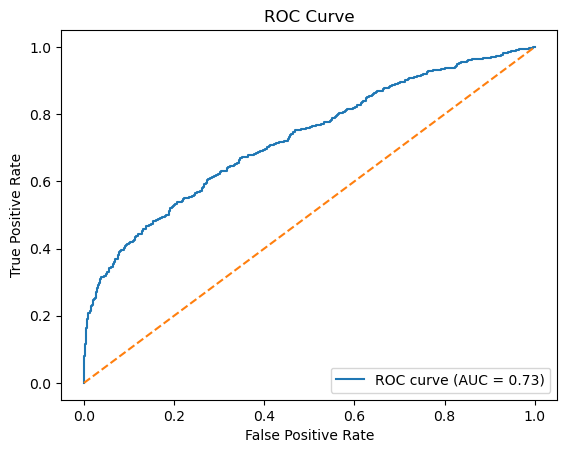

LSTM - window size = 16
TP: 369
TN: 637
FP: 168
FN: 223
Sensitivity: 0.6233
Specificity: 0.7913
Accuracy: 0.7201
Positive prediction value: 0.6872


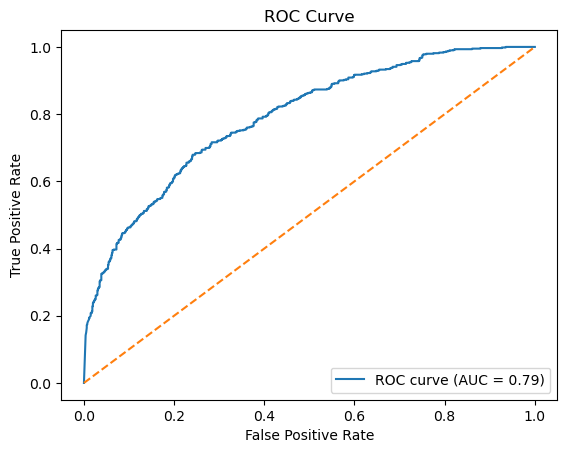

RNN - window size = 18
TP: 173
TN: 785
FP: 31
FN: 411
Sensitivity: 0.2962
Specificity: 0.9620
Accuracy: 0.6843
Positive prediction value: 0.8480


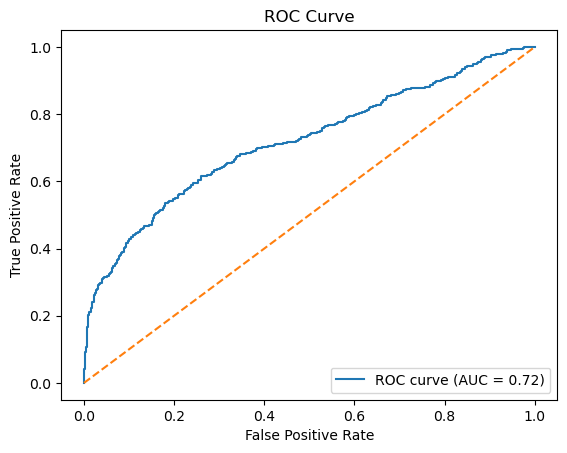

LSTM - window size = 18
TP: 398
TN: 610
FP: 206
FN: 186
Sensitivity: 0.6815
Specificity: 0.7475
Accuracy: 0.7200
Positive prediction value: 0.6589


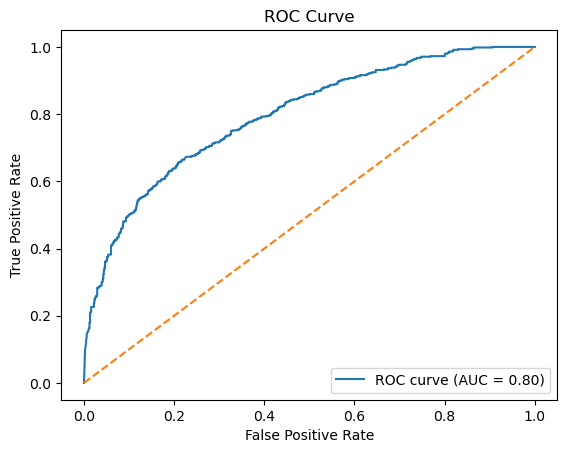

RNN - window size = 20
TP: 246
TN: 718
FP: 81
FN: 423
Sensitivity: 0.3677
Specificity: 0.8986
Accuracy: 0.6567
Positive prediction value: 0.7523


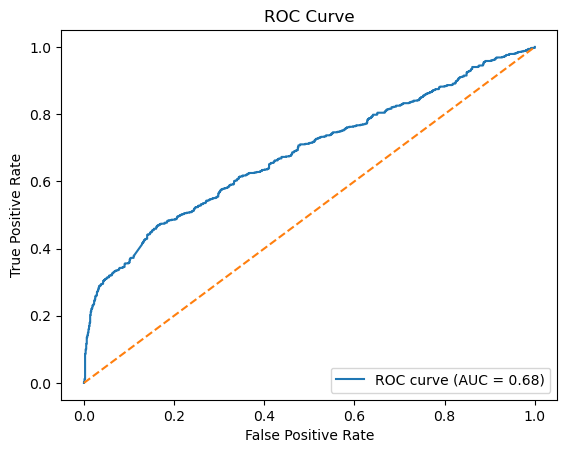

LSTM - window size = 20
TP: 445
TN: 637
FP: 162
FN: 224
Sensitivity: 0.6652
Specificity: 0.7972
Accuracy: 0.7371
Positive prediction value: 0.7331


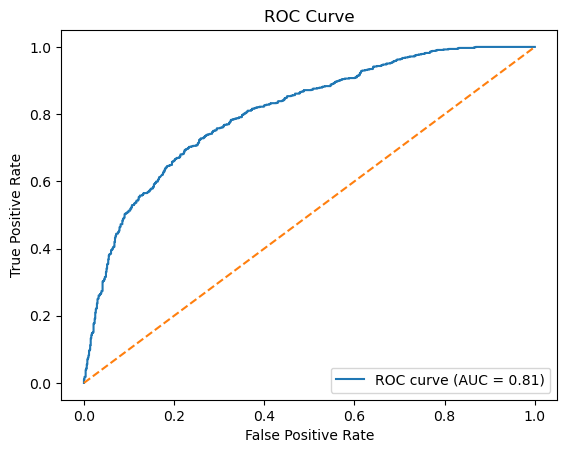

RNN - window size = 22
TP: 240
TN: 750
FP: 55
FN: 423
Sensitivity: 0.3620
Specificity: 0.9317
Accuracy: 0.6744
Positive prediction value: 0.8136


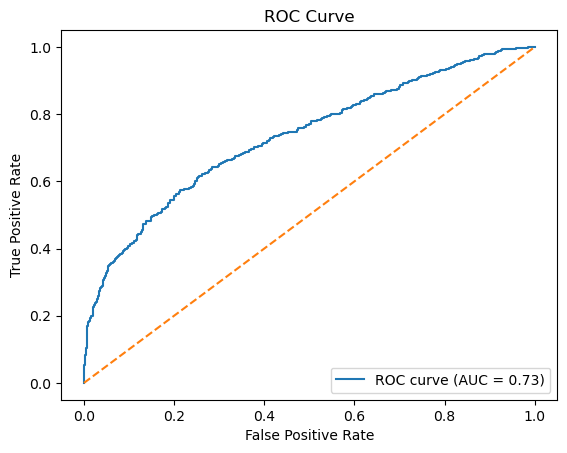

LSTM - window size = 22
TP: 434
TN: 642
FP: 163
FN: 229
Sensitivity: 0.6546
Specificity: 0.7975
Accuracy: 0.7330
Positive prediction value: 0.7270


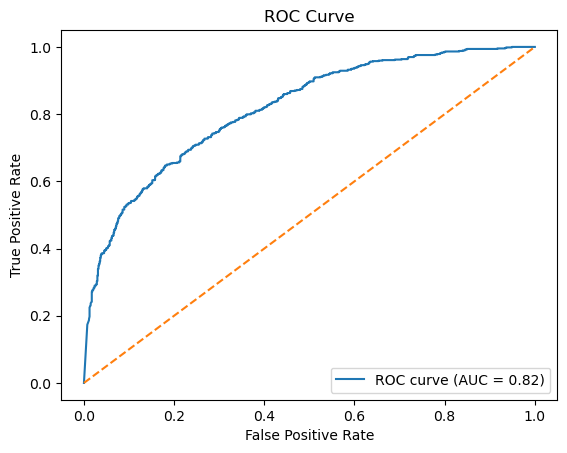

RNN - window size = 24
TP: 379
TN: 637
FP: 185
FN: 274
Sensitivity: 0.5804
Specificity: 0.7749
Accuracy: 0.6888
Positive prediction value: 0.6720


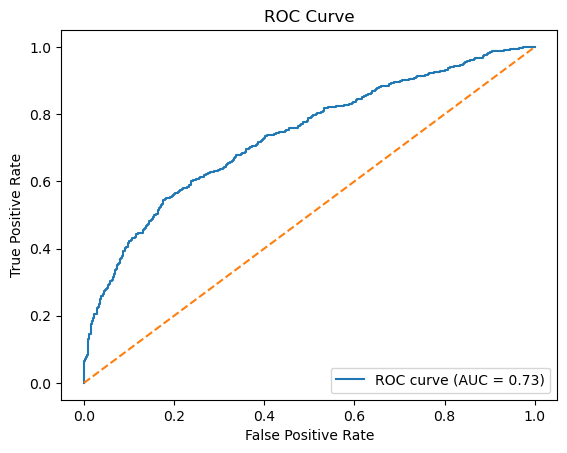

LSTM - window size = 24
TP: 482
TN: 654
FP: 168
FN: 171
Sensitivity: 0.7381
Specificity: 0.7956
Accuracy: 0.7702
Positive prediction value: 0.7415


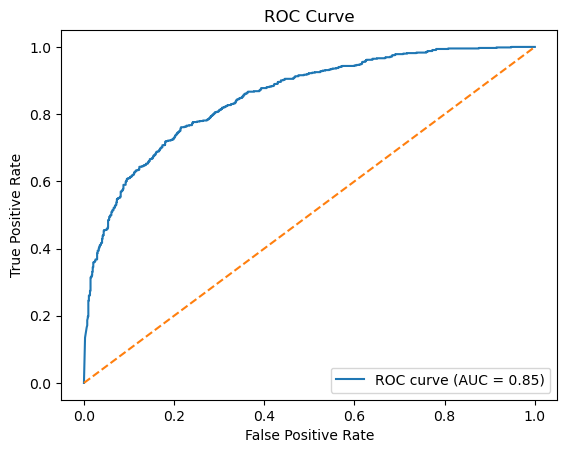

RNN - window size = 26
TP: 408
TN: 650
FP: 153
FN: 261
Sensitivity: 0.6099
Specificity: 0.8095
Accuracy: 0.7188
Positive prediction value: 0.7273


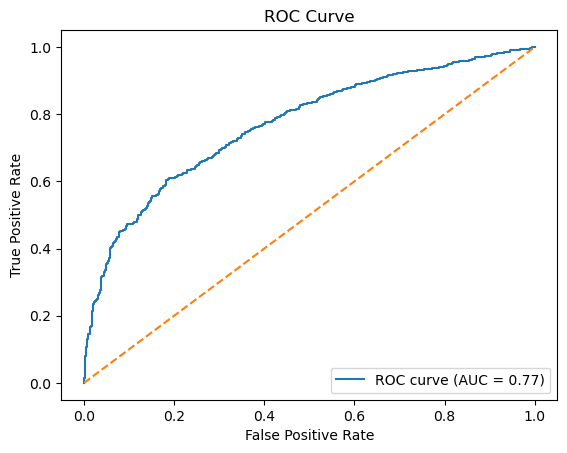

LSTM - window size = 26
TP: 527
TN: 624
FP: 179
FN: 142
Sensitivity: 0.7877
Specificity: 0.7771
Accuracy: 0.7819
Positive prediction value: 0.7465


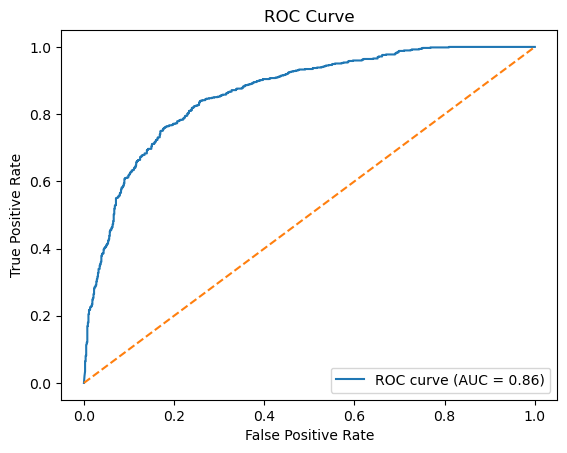

In [395]:
WINDOW_SIZES = [16,18,20,22,24,26]
OPTIMIZER_TYPES = ["SGD", "Adam", "SGD", "Adam", "Adam", "Adam", "SGD", "Adam", "Adam", "Adam", "Adam", "Adam"]
BATCH_SIZES = [64,16,32,64,32,16,32,16,64,32,64,128]                
LEARNING_RATES = [0.01,0.005,0.01,0.01,0.005,0.01,0.01,0.005,0.005,0.01,0.005,0.01]
HIDDEN_SIZES = [30,30,35,40,35,40,40,40,35,35,30,40] 

i = -1
for WINDOW_SIZE in WINDOW_SIZES:
    
    i += 1
    
    if WINDOW_SIZE == 16:
        sequences = final16[str(WINDOW_SIZE)].to_numpy()
        labels = final16["Label"].to_numpy()
    elif WINDOW_SIZE == 18:
        sequences = final18[str(WINDOW_SIZE)].to_numpy()
        labels = final18["Label"].to_numpy()
    elif WINDOW_SIZE == 20:
        sequences = final20[str(WINDOW_SIZE)].to_numpy()
        labels = final20["Label"].to_numpy()
    elif WINDOW_SIZE == 22:
        sequences = final22[str(WINDOW_SIZE)].to_numpy()
        labels = final22["Label"].to_numpy()
    elif WINDOW_SIZE == 24:
        sequences = final24[str(WINDOW_SIZE)].to_numpy()
        labels = final24["Label"].to_numpy()
    elif WINDOW_SIZE == 26:
        sequences = final26[str(WINDOW_SIZE)].to_numpy()
        labels = final26["Label"].to_numpy()
    
    OPTIMIZER_TYPE = OPTIMIZER_TYPES[i]
    BATCH_SIZE = BATCH_SIZES[i]
    LEARNING_RATE = LEARNING_RATES[i]
    HIDDEN_SIZE = HIDDEN_SIZES[i]
        
    unique_sequences, indices = np.unique(sequences, return_index=True)
    labels = labels[indices]
    encoded = [one_hot_encode(seq) for seq in unique_sequences]
    train_sequences, test_sequences, train_labels, test_labels = train_test_split(
        encoded, labels, train_size=0.8, shuffle=True, random_state=1234
    )

    train_sequences, val_sequences, train_labels, val_labels = train_test_split(
        train_sequences, train_labels, train_size=0.75, shuffle=True, random_state=1234
    )
    
    train_sequences = np.array(train_sequences, dtype=np.float32)
    test_sequences = np.array(test_sequences, dtype=np.float32)
    val_sequences = np.array(val_sequences, dtype=np.float32)
    train_labels = np.array(train_labels, dtype=np.float32)
    test_labels = np.array(test_labels, dtype=np.float32)
    val_labels = np.array(val_labels, dtype=np.float32)
    
    train_sequences = torch.tensor(train_sequences, dtype=torch.float32).to(device)
    test_sequences = torch.tensor(test_sequences, dtype=torch.float32).to(device)
    val_sequences = torch.tensor(val_sequences, dtype=torch.float32).to(device)
    train_labels = torch.tensor(train_labels, dtype=torch.float32).to(device)
    test_labels = torch.tensor(test_labels, dtype=torch.float32).to(device)
    val_labels = torch.tensor(val_labels, dtype=torch.float32).to(device)

    train_dataset = EpitopeDataset(train_sequences, train_labels)
    test_dataset = EpitopeDataset(test_sequences, test_labels)
    val_dataset = EpitopeDataset(val_sequences, val_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = RNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
    if OPTIMIZER_TYPE == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    elif OPTIMIZER_TYPE == "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
    model = train_model(model, train_loader, val_loader, loss_function, optimizer, EPOCHS)
    print("RNN - window size = " + str(WINDOW_SIZE))
    test_model(model, test_loader, to_print=True)
    
    i += 1
    
    OPTIMIZER_TYPE = OPTIMIZER_TYPES[i]
    BATCH_SIZE = BATCH_SIZES[i]
    LEARNING_RATE = LEARNING_RATES[i]
    HIDDEN_SIZE = HIDDEN_SIZES[i]
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = LSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
    if OPTIMIZER_TYPE == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    elif OPTIMIZER_TYPE == "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
    model = train_model(model, train_loader, val_loader, loss_function, optimizer, EPOCHS)
    print("LSTM - window size = " + str(WINDOW_SIZE))
    test_model(model, test_loader, to_print=True)

Rječnik sa izvornim sekvencama kao ključevima i epitopima koje sadrže kao vrijednostima. Bit će korišteno za testiranje modela pomoću posmičnog prozora.

In [388]:
from collections import defaultdict
epitopes_dict = defaultdict(list)

for _, row in combined[combined["Epitope"].notna()].iterrows():
    source = row["Source molecule"]
    epitope = row["Epitope"]
    epitopes_dict[source].append(epitope)

epitopes_dict = dict(epitopes_dict)


Generiranje testnog skupa podataka

In [393]:
sequences_test = []
labels_test = []
for source, epitopes in epitopes_dict.items():
    for j in range(len(source) - WINDOW_SIZE + 1):
        window = source[j:j + WINDOW_SIZE]
        sequences_test.append(window)
        cnt = 0
        for epitope in epitopes:
            if epitope in window:
                cnt = 1
                labels_test.append(1)
                break
        if cnt == 0:
            labels_test.append(0)
            
sequences_test = np.array(sequences_test)
labels_test = np.array(labels_test)
encoded = [one_hot_encode(seq) for seq in sequences_test]

test_sequences = np.array(encoded, dtype=np.float32)
test_sequences = test_sequences
test_labels = np.array(labels_test, dtype=np.float32)
test_labels = test_labels
test_sequences = torch.tensor(test_sequences, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.float32).to(device)
test_dataset = EpitopeDataset(test_sequences, test_labels)

Isprobavanje prethodnih najboljih modela, sada korištenjem posmičnog prozora

RNN - window size = 16
TP: 7467
TN: 55053
FP: 12471
FN: 13316
Sensitivity: 0.3593
Specificity: 0.8153
Accuracy: 0.7080
Positive prediction value: 0.3745


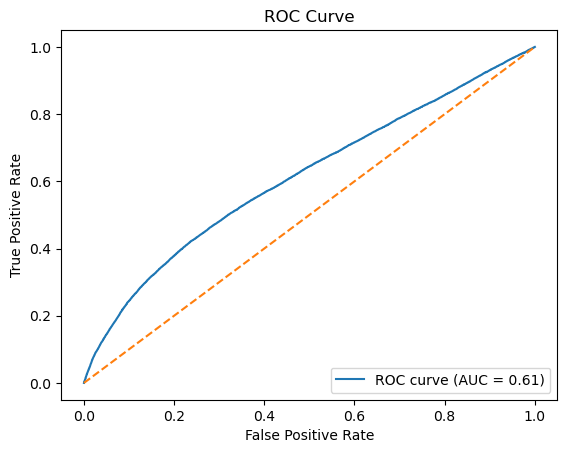

LSTM - window size = 16
TP: 12474
TN: 44919
FP: 22605
FN: 8309
Sensitivity: 0.6002
Specificity: 0.6652
Accuracy: 0.6499
Positive prediction value: 0.3556


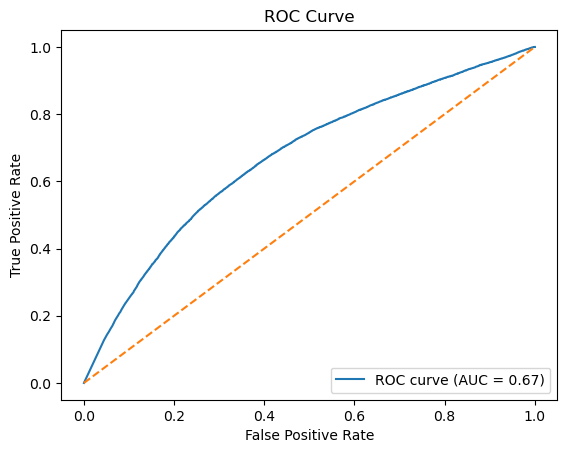

RNN - window size = 18
TP: 5980
TN: 58852
FP: 8672
FN: 14803
Sensitivity: 0.2877
Specificity: 0.8716
Accuracy: 0.7342
Positive prediction value: 0.4081


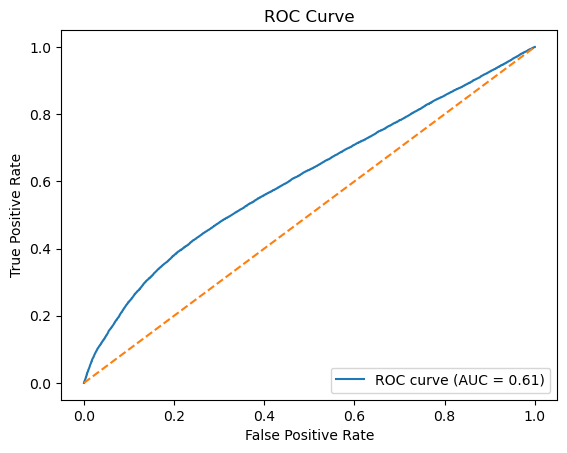

LSTM - window size = 18
TP: 14266
TN: 42040
FP: 25484
FN: 6517
Sensitivity: 0.6864
Specificity: 0.6226
Accuracy: 0.6376
Positive prediction value: 0.3589


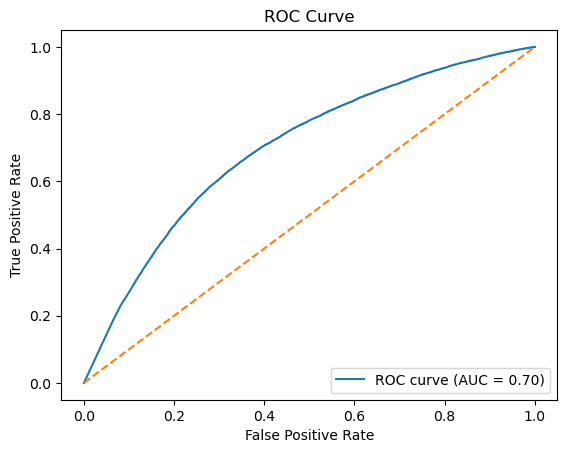

RNN - window size = 20
TP: 9922
TN: 48988
FP: 18536
FN: 10861
Sensitivity: 0.4774
Specificity: 0.7255
Accuracy: 0.6671
Positive prediction value: 0.3487


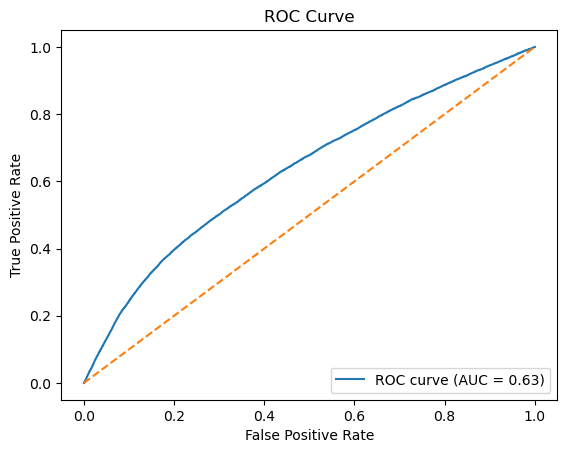

LSTM - window size = 20
TP: 14374
TN: 41575
FP: 25949
FN: 6409
Sensitivity: 0.6916
Specificity: 0.6157
Accuracy: 0.6336
Positive prediction value: 0.3565


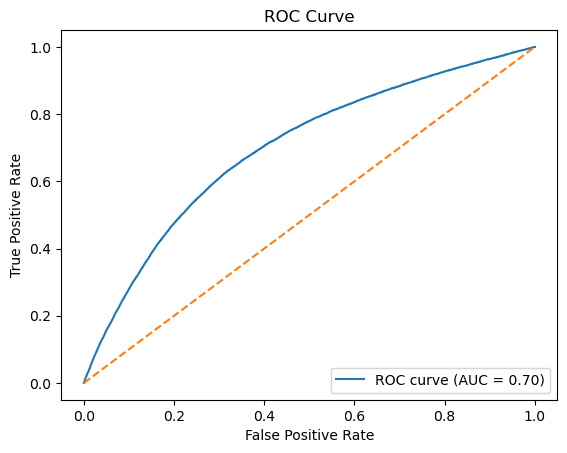

RNN - window size = 22
TP: 14360
TN: 28058
FP: 39466
FN: 6423
Sensitivity: 0.6909
Specificity: 0.4155
Accuracy: 0.4803
Positive prediction value: 0.2668


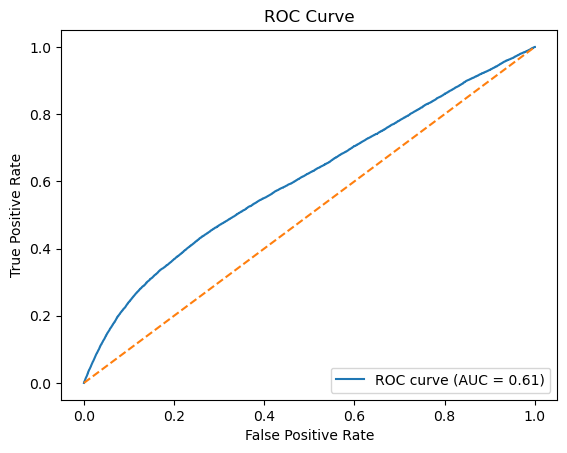

LSTM - window size = 22
TP: 15067
TN: 39507
FP: 28017
FN: 5716
Sensitivity: 0.7250
Specificity: 0.5851
Accuracy: 0.6180
Positive prediction value: 0.3497


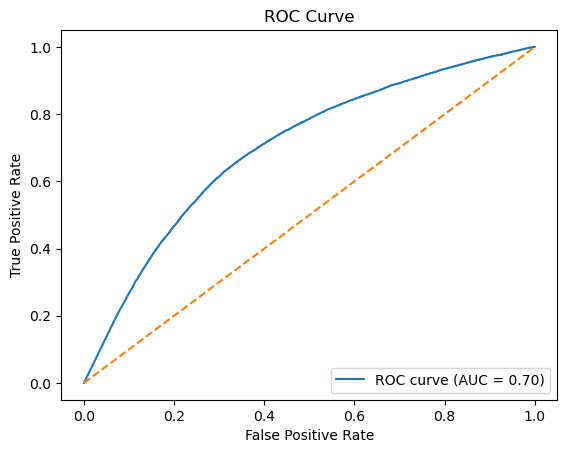

RNN - window size = 24
TP: 13888
TN: 36626
FP: 30898
FN: 6895
Sensitivity: 0.6682
Specificity: 0.5424
Accuracy: 0.5720
Positive prediction value: 0.3101


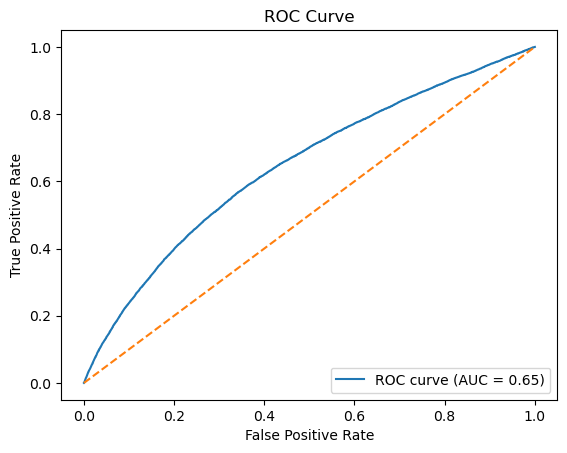

LSTM - window size = 24
TP: 14939
TN: 40544
FP: 26980
FN: 5844
Sensitivity: 0.7188
Specificity: 0.6004
Accuracy: 0.6283
Positive prediction value: 0.3564


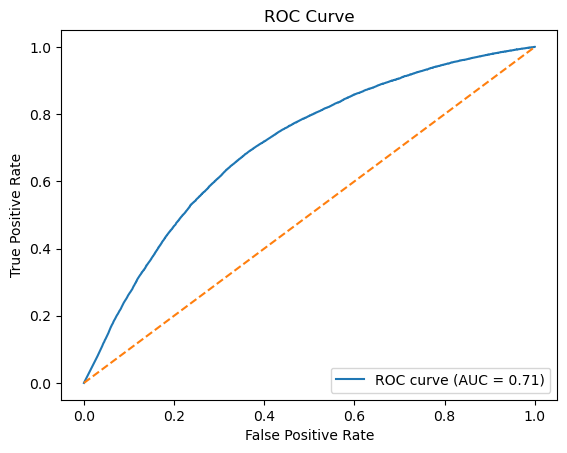

RNN - window size = 26
TP: 12554
TN: 39006
FP: 28518
FN: 8229
Sensitivity: 0.6041
Specificity: 0.5777
Accuracy: 0.5839
Positive prediction value: 0.3057


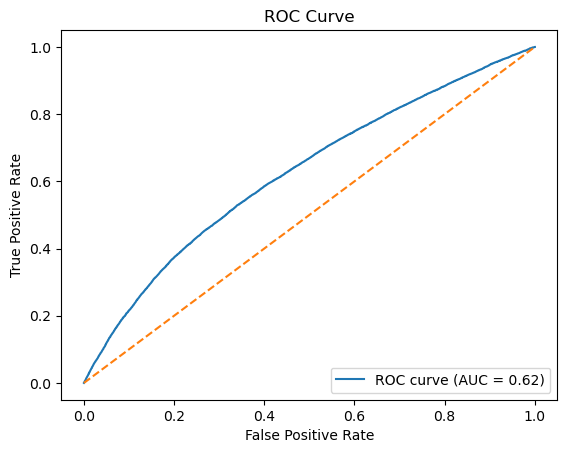

LSTM - window size = 26
TP: 16032
TN: 34341
FP: 33183
FN: 4751
Sensitivity: 0.7714
Specificity: 0.5086
Accuracy: 0.5704
Positive prediction value: 0.3258


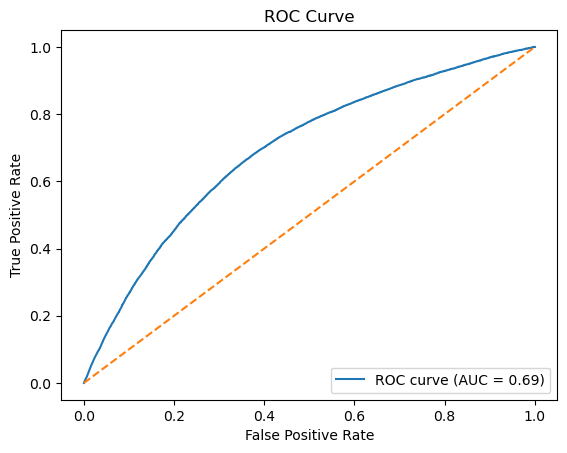

In [394]:
WINDOW_SIZES = [16,18,20,22,24,26]
OPTIMIZER_TYPES = ["SGD", "Adam", "SGD", "Adam", "Adam", "Adam", "SGD", "Adam", "Adam", "Adam", "Adam", "Adam"]
BATCH_SIZES = [64,16,32,64,32,16,32,16,64,32,64,128]                
LEARNING_RATES = [0.01,0.005,0.01,0.01,0.005,0.01,0.01,0.005,0.005,0.01,0.005,0.01]
HIDDEN_SIZES = [30,30,35,40,35,40,40,40,35,35,30,40] 

i = -1
for WINDOW_SIZE in WINDOW_SIZES:
    
    i += 1
    
    if WINDOW_SIZE == 16:
        sequences = final16[str(WINDOW_SIZE)].to_numpy()
        labels = final16["Label"].to_numpy()
    elif WINDOW_SIZE == 18:
        sequences = final18[str(WINDOW_SIZE)].to_numpy()
        labels = final18["Label"].to_numpy()
    elif WINDOW_SIZE == 20:
        sequences = final20[str(WINDOW_SIZE)].to_numpy()
        labels = final20["Label"].to_numpy()
    elif WINDOW_SIZE == 22:
        sequences = final22[str(WINDOW_SIZE)].to_numpy()
        labels = final22["Label"].to_numpy()
    elif WINDOW_SIZE == 24:
        sequences = final24[str(WINDOW_SIZE)].to_numpy()
        labels = final24["Label"].to_numpy()
    elif WINDOW_SIZE == 26:
        sequences = final26[str(WINDOW_SIZE)].to_numpy()
        labels = final26["Label"].to_numpy()
    
    OPTIMIZER_TYPE = OPTIMIZER_TYPES[i]
    BATCH_SIZE = BATCH_SIZES[i]
    LEARNING_RATE = LEARNING_RATES[i]
    HIDDEN_SIZE = HIDDEN_SIZES[i]
        
    unique_sequences, indices = np.unique(sequences, return_index=True)
    labels = labels[indices]
    encoded = [one_hot_encode(seq) for seq in unique_sequences]
    train_sequences, test_sequences, train_labels, test_labels = train_test_split(
        encoded, labels, train_size=0.8, shuffle=True, random_state=1234
    )

    train_sequences, val_sequences, train_labels, val_labels = train_test_split(
        train_sequences, train_labels, train_size=0.75, shuffle=True, random_state=1234
    )
    
    train_sequences = np.array(train_sequences, dtype=np.float32)
    test_sequences = np.array(test_sequences, dtype=np.float32)
    val_sequences = np.array(val_sequences, dtype=np.float32)
    train_labels = np.array(train_labels, dtype=np.float32)
    test_labels = np.array(test_labels, dtype=np.float32)
    val_labels = np.array(val_labels, dtype=np.float32)
    
    train_sequences = torch.tensor(train_sequences, dtype=torch.float32).to(device)
    test_sequences = torch.tensor(test_sequences, dtype=torch.float32).to(device)
    val_sequences = torch.tensor(val_sequences, dtype=torch.float32).to(device)
    train_labels = torch.tensor(train_labels, dtype=torch.float32).to(device)
    test_labels = torch.tensor(test_labels, dtype=torch.float32).to(device)
    val_labels = torch.tensor(val_labels, dtype=torch.float32).to(device)

    train_dataset = EpitopeDataset(train_sequences, train_labels)
    test_dataset = EpitopeDataset(test_sequences, test_labels)
    val_dataset = EpitopeDataset(val_sequences, val_labels)

    model = RNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
    if OPTIMIZER_TYPE == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    elif OPTIMIZER_TYPE == "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
    model = train_model(model, train_loader, val_loader, loss_function, optimizer, EPOCHS)
    print("RNN - window size = " + str(WINDOW_SIZE))
    test_model(model, test_loader, to_print=True)
    
    i += 1
    
    OPTIMIZER_TYPE = OPTIMIZER_TYPES[i]
    BATCH_SIZE = BATCH_SIZES[i]
    LEARNING_RATE = LEARNING_RATES[i]
    HIDDEN_SIZE = HIDDEN_SIZES[i]
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = LSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
    if OPTIMIZER_TYPE == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    elif OPTIMIZER_TYPE == "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
    model = train_model(model, train_loader, val_loader, loss_function, optimizer, EPOCHS)
    print("LSTM - window size = " + str(WINDOW_SIZE))
    test_model(model, test_loader, to_print=True)